<a href="https://colab.research.google.com/github/An210/ML/blob/main/LSTM_Crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [197]:
!pip install cryptocompare
!pip install seaborn
import seaborn as sns
import requests
import pandas as pd
from datetime import datetime
import cryptocompare
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

def get_historical_price_data(period=360):
    # Get the current timestamp
    end_time = datetime.now()

    # Calculate the start time (30 days ago)
    start_time = end_time - timedelta(days=period)

    # Convert timestamps to Unix timestamps
    end_timestamp = int(end_time.timestamp())
    start_timestamp = int(start_time.timestamp())

    # Get historical price data
    price_data = cryptocompare.get_historical_price_day(
        'ETH', 'USD', limit=period, toTs=end_timestamp, exchange='CCCAGG'
    )

    # Create a Pandas DataFrame
    df = pd.DataFrame(price_data)

    # Convert 'time' column to datetime objects
    df['time'] = pd.to_datetime(df['time'], unit='s')

    # Rename columns to match your desired format
    df = df.rename(
        columns={
            'time': 'Timestamp',
            'high': 'High',
            'low': 'Low',
            'open': 'Open',
            'volumefrom': 'VolumeFrom',
            'volumeto': 'VolumeTo',
            'close': 'Close',
        }
    )

    return df

# Get historical price data
historical_data = get_historical_price_data()
historical_data = historical_data.drop(['conversionType', 'conversionSymbol'], axis=1)

# Print the DataFrame
print(historical_data.sort_values(by='Timestamp', ascending=False))

     Timestamp     High      Low     Open  VolumeFrom      VolumeTo    Close
360 2024-11-15  3093.01  3016.13  3059.11   229482.23  7.035389e+08  3060.06
359 2024-11-14  3242.46  3029.87  3191.32  1094612.33  3.442350e+09  3059.11
358 2024-11-13  3339.13  3121.10  3247.18  1694646.90  5.472868e+09  3191.32
357 2024-11-12  3446.83  3210.71  3375.79  1572933.12  5.174595e+09  3247.18
356 2024-11-11  3391.44  3108.06  3186.06  1371655.28  4.474445e+09  3375.79
..         ...      ...      ...      ...         ...           ...      ...
4   2023-11-25  2091.51  2067.12  2082.24    82529.48  1.718206e+08  2084.06
3   2023-11-24  2133.82  2059.80  2062.63   274783.65  5.768434e+08  2082.24
2   2023-11-23  2088.81  2040.70  2064.08   167576.88  3.454655e+08  2062.63
1   2023-11-22  2092.34  1930.15  1933.76   311184.99  6.320494e+08  2064.08
0   2023-11-21  2035.52  1932.84  2022.62   322140.51  6.409346e+08  1933.76

[361 rows x 7 columns]


In [198]:
X = historical_data.copy()
y = X.pop("Close")
X['Timestamp'] = pd.to_datetime(X['Timestamp']).astype('int64') // 10**9

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# Verify integer types and correct them if needed
X = X.apply(lambda x: pd.to_numeric(x, downcast='integer'))

# Check for discrete features
discrete_features = X.dtypes == 'int'

# Define function for MI scores
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# Calculate MI scores
mi_scores = make_mi_scores(X, y, discrete_features)
print("\nSelected MI Scores:\n", mi_scores[::1])





Selected MI Scores:
 High          2.313141
Low           2.227073
Open          1.713106
Timestamp     1.549160
VolumeFrom    0.101385
VolumeTo      0.097486
Name: MI Scores, dtype: float64


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:378: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


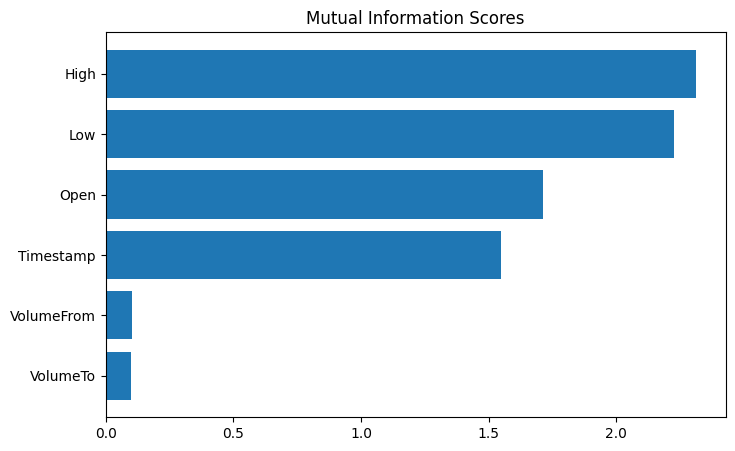

In [199]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

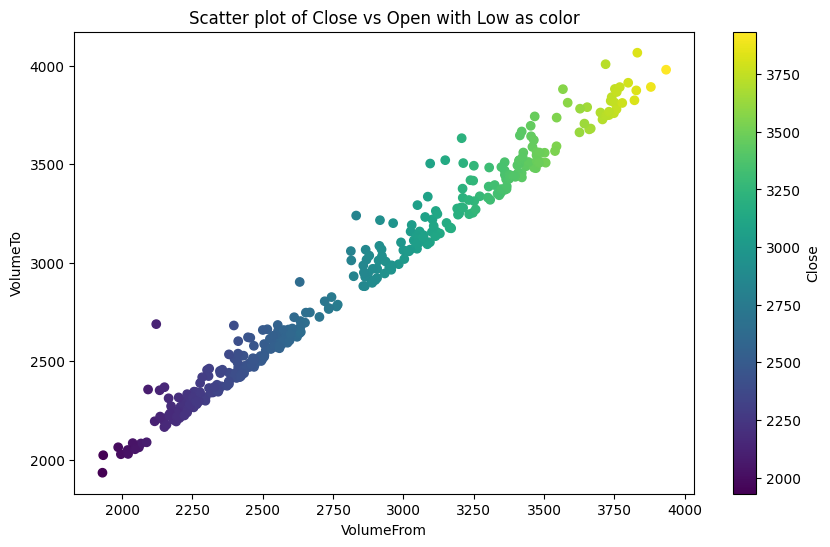

In [200]:


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
scatter = plt.scatter(historical_data["Low"], historical_data["Open"], c=historical_data["Low"], cmap="viridis")
plt.colorbar(scatter, label="Close")
plt.xlabel("VolumeFrom")
plt.ylabel("VolumeTo")
plt.title("Scatter plot of Close vs Open with Low as color")
plt.show()

In [201]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# Import MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(historical_data[['High', 'Low', 'Open', 'VolumeFrom', 'VolumeTo', 'Close']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length + 1])
    return np.array(sequences)

seq_length = 10  # You can adjust this based on your data
sequences = create_sequences(scaled_data, seq_length)

# Split into features (X) and target (y)
X = sequences[:, :-1]
y = sequences[:, -1, -1]  # We are predicting the 'Close' price
print(X)
print(y)
# Split into training and validation sets
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]


[[[0.         0.00134216 0.04167937 0.15799163 0.08849459 0.        ]
  [0.02761993 0.         0.         0.15127062 0.08681846 0.06112599]
  [0.02590402 0.05515834 0.06112599 0.06316958 0.03275672 0.06044587]
  ...
  [0.01958964 0.03268088 0.04404805 0.1103861  0.06175332 0.05409969]
  [0.01938548 0.04478528 0.05409969 0.07865536 0.04194927 0.04475162]
  [0.00960524 0.04547881 0.04475162 0.06373777 0.03236521 0.05589613]]

 [[0.02761993 0.         0.         0.15127062 0.08681846 0.06112599]
  [0.02590402 0.05515834 0.06112599 0.06316958 0.03275672 0.06044587]
  [0.04778316 0.06468818 0.06044587 0.12893904 0.07640429 0.06964385]
  ...
  [0.01938548 0.04478528 0.05409969 0.07865536 0.04194927 0.04475162]
  [0.00960524 0.04547881 0.04475162 0.06373777 0.03236521 0.05589613]
  [0.03689949 0.05780275 0.05589613 0.13731677 0.08123271 0.07244405]]

 [[0.02590402 0.05515834 0.06112599 0.06316958 0.03275672 0.06044587]
  [0.04778316 0.06468818 0.06044587 0.12893904 0.07640429 0.06964385]
  [0

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout  # Import Bidirectional and Dropout
# Import MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf #Import Tensorflow

model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(seq_length, X.shape[2])))  # Bidirectional LSTM
model.add(Dropout(0.3))  # Increased dropout rate
model.add(Bidirectional(LSTM(50)))  # Bidirectional LSTM
model.add(Dropout(0.3))
model.add(Dense(25))
model.add(Dense(1))

# Compile with adjusted learning rate and potential regularization
optimizer = keras.optimizers.Adam(learning_rate=0.0005)  # Reduced learning rate
model.compile(optimizer=optimizer, loss='mean_squared_error')


model.fit(X_train, y_train, batch_size=1, epochs=20)
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')

# Make predictions
predictions = model.predict(X_val)

# Inverse transform the predictions to get the actual close prices
predictions = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], X.shape[2] - 1)), predictions), axis=1))[:, -1]
actual_close_prices = historical_data['Close'].iloc[-len(y_val):].values
timestamps = historical_data['Timestamp'].iloc[-len(y_val):].values  # Assuming 'Timestamp' is the column name for timestamps

# Print the predictions along with timestamps
for timestamp, actual, predicted in zip(timestamps, actual_close_prices, predictions):
    print(f'Timestamp: {timestamp}, Actual Close Price: {actual}, Predicted Close Price: {predicted}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - loss: 0.0359
Epoch 2/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0142
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0131
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0098
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.0110
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0078
Epoch 7/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 0.0065
Epoch 8/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0066
Epoch 9/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0075
Epoch 10/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0070
Epoch 11/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0054
Epoch 12/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.0081
Epoch 13/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.0052
Epoch 14/20
202/280 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0079

In [ ]:
# ... (your existing code for data loading, preprocessing, model training with cross-validation) ...

# Number of days to predict ahead
num_days_ahead = 20

# Get the last 'seq_length' data points from historical_data
current_sequence = scaled_data[-seq_length:]
predictions = []
timestamps = []
trade_timestamps = []  # Initialize trade_timestamps as a list

# Loop to predict for the next 'num_days_ahead' days
for i in range(num_days_ahead):
    # Reshape the current sequence to match the model's input shape
    current_sequence = current_sequence.reshape((1, seq_length, scaled_data.shape[1]))

    # Make prediction for the next day
    prediction = model.predict(current_sequence)

    # Inverse transform prediction to get actual price
    prediction = scaler.inverse_transform(np.concatenate((np.zeros((prediction.shape[0], scaled_data.shape[1] - 1)), prediction), axis=1))[:, -1]

    # Reshape the prediction to match the dimensions of current_sequence
    prediction_reshaped = np.repeat(prediction[:, np.newaxis], scaled_data.shape[1], axis=1)
    prediction_reshaped = prediction_reshaped.reshape(1, 1, scaled_data.shape[1])

    #Create a temporary DataFrame for scaling
    temp_df = pd.DataFrame(prediction_reshaped.reshape(1, -1), columns=['High', 'Low', 'Open', 'VolumeFrom', 'VolumeTo', 'Close'])

    #Scale using the temporary DataFrame
    prediction_scaled = scaler.transform(temp_df).reshape(1, 1, scaled_data.shape[1])

    # Get the timestamp for the prediction
    timestamp = historical_data['Timestamp'].iloc[-1] + pd.Timedelta(days=i + 1)  # Add i+1 days to the last timestamp

    # Print prediction with timestamp
    print(f"Predicted Ethereum price for {timestamp}: {prediction[0]}")
    predictions.append(prediction[0])
    timestamps.append(timestamp)
    # Update the current sequence for the next prediction
    current_sequence = np.append(current_sequence[:, 1:, :], prediction_scaled, axis=1)  # Append the prediction to the sequence and remove the first element

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(historical_data['Timestamp']), historical_data['Close'], label='Original Close Price', marker='o')
plt.plot(timestamps, predictions, label='Predicted Close Price', marker='x', linestyle='--')
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.title('Ethereum Close Price Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
backtest_start_date = '2024-01-01'  # Adjust this to your desired start date
backtest_end_date = '2024-11-15'  # Adjust this to your desired end date

# Filter historical data for the backtesting period
backtest_data = historical_data[(historical_data['Timestamp'] >= backtest_start_date) & (historical_data['Timestamp'] <= backtest_end_date)]

# Prepare backtesting data
scaled_backtest_data = scaler.transform(backtest_data[['High', 'Low', 'Open', 'VolumeFrom', 'VolumeTo', 'Close']])
backtest_sequences = create_sequences(scaled_backtest_data, seq_length)
X_backtest = backtest_sequences[:, :-1]
y_backtest = backtest_sequences[:, -1, -1]  # We are predicting the 'Close' price

# Make predictions on the backtesting data
backtest_predictions = model.predict(X_backtest)

# Inverse transform the predictions to get the actual close prices
backtest_predictions = scaler.inverse_transform(np.concatenate((np.zeros((backtest_predictions.shape[0], X_backtest.shape[2] - 1)), backtest_predictions), axis=1))[:, -1]

# Evaluate backtesting performance
rmse = np.sqrt(mean_squared_error(backtest_data['Close'].iloc[seq_length:], backtest_predictions))
r2 = r2_score(backtest_data['Close'].iloc[seq_length:], backtest_predictions)
mape = mean_absolute_percentage_error(backtest_data['Close'].iloc[seq_length:], backtest_predictions)

print(f'Backtesting RMSE: {rmse}')
print(f'Backtesting R-squared: {r2}')
print(f'Backtesting MAPE: {mape}')

# Plotting the backtesting results
plt.figure(figsize=(12, 6))
plt.plot(backtest_data['Timestamp'].iloc[seq_length:], backtest_data['Close'].iloc[seq_length:], label='Actual', color='blue')
plt.plot(backtest_data['Timestamp'].iloc[seq_length:], backtest_predictions, label='Predicted', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Ethereum Price')
plt.title('Ethereum Price Backtesting')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def run_backtest(backtest_predictions, backtest_data, seq_length, initial_budget=10000,
                 position_size=0.2, min_trade_amount=10):
    """
    Run backtest with support for partial units trading

    Parameters:
    -----------
    backtest_predictions : array-like
        Model predictions for buy/sell signals
    backtest_data : pandas.DataFrame
        Historical price data with 'Close' column
    seq_length : int
        Sequence length used in the model
    initial_budget : float
        Starting budget for trading
    position_size : float
        Percentage of budget to use per trade (0.0 to 1.0)
    min_trade_amount : float
        Minimum amount in currency units for a trade

    Returns:
    --------
    dict
        Dictionary containing backtest results and metrics
    """
    profit_loss_backtest = []
    trades = []
    current_budget = initial_budget
    current_holdings = 0  # Amount of coins/shares held

    # Trading metrics
    num_trades = 0
    winning_trades = 0
    losing_trades = 0

    # Ensure proper length for backtesting
    test_length = min(len(backtest_predictions), len(backtest_data))

    for i in range(1, test_length):
        current_price = backtest_data['Close'].iloc[i - 1 + seq_length]
        print(i - 1 + seq_length)
        next_price = backtest_data['Close'].iloc[i + seq_length]

        # Calculate trade size based on position sizing
        max_trade_amount = current_budget * position_size

        if backtest_predictions[i - 1] > current_price:  # Buy signal
            if current_budget >= min_trade_amount:
                # Calculate amount to buy
                trade_amount = min(max_trade_amount, current_budget)
                coins_to_buy = trade_amount / current_price

                # Execute buy
                current_holdings += coins_to_buy
                current_budget -= trade_amount

                trades.append({
                    'type': 'buy',
                    'price': current_price,
                    'amount': coins_to_buy,
                    'value': trade_amount,
                    'timestamp': backtest_data.index[i - 1 + seq_length]
                })

                profit_loss_backtest.append(0)  # No immediate P/L on buy
                num_trades += 1
            else:
                profit_loss_backtest.append(0)

        else:  # Sell signal
            if current_holdings > 0:
                # Calculate sell value
                sell_value = current_holdings * current_price
                profit_loss = current_holdings * (current_price - trades[-1]['price'])

                # Track trade outcome
                if profit_loss > 0:
                    winning_trades += 1
                elif profit_loss < 0:
                    losing_trades += 1

                # Execute sell
                current_budget += sell_value
                profit_loss_backtest.append(profit_loss)

                trades.append({
                    'type': 'sell',
                    'price': current_price,
                    'amount': current_holdings,
                    'value': sell_value,
                    'profit_loss': profit_loss,
                    'timestamp': backtest_data.index[i - 1 + seq_length]
                })

                current_holdings = 0
                num_trades += 1
            else:
                profit_loss_backtest.append(0)

    # Calculate final metrics
    cumulative_profit_loss = sum(profit_loss_backtest)
    win_rate = winning_trades / num_trades if num_trades > 0 else 0

    # Calculate current portfolio value (cash + holdings)
    final_holding_value = current_holdings * backtest_data['Close'].iloc[-1]
    total_portfolio_value = current_budget + final_holding_value

    # Calculate return metrics
    total_return = (total_portfolio_value - initial_budget) / initial_budget * 100

    return {
        'trades': trades,
        'profit_loss_history': profit_loss_backtest,
        'cumulative_profit_loss': cumulative_profit_loss,
        'final_budget': current_budget,
        'final_holdings': current_holdings,
        'final_portfolio_value': total_portfolio_value,
        'total_return_pct': total_return,
        'num_trades': num_trades,
        'win_rate': win_rate,
        'metrics': {
            'winning_trades': winning_trades,
            'losing_trades': losing_trades,
            'win_rate': win_rate
        }
    }

def plot_backtest_results(backtest_results, backtest_data):
    """
    Plot backtest results including portfolio value and trade points
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot 1: Cumulative Profit/Loss
    cumulative_pl = np.cumsum(backtest_results['profit_loss_history'])
    ax1.plot(cumulative_pl)
    ax1.set_title('Cumulative Profit/Loss Over Time')
    ax1.set_xlabel('Trade Number')
    ax1.set_ylabel('Profit/Loss')
    ax1.grid(True)

    # Plot 2: Price with Buy/Sell points
    ax2.plot(backtest_data['Close'], label='Price', alpha=0.7)

    # Plot buy points
    buy_trades = [t for t in backtest_results['trades'] if t['type'] == 'buy']
    if buy_trades:
        buy_times = [t['timestamp'] for t in buy_trades]
        buy_prices = [t['price'] for t in buy_trades]
        ax2.scatter(buy_times, buy_prices, color='green', marker='^', label='Buy')

    # Plot sell points
    sell_trades = [t for t in backtest_results['trades'] if t['type'] == 'sell']
    if sell_trades:
        sell_times = [t['timestamp'] for t in sell_trades]
        sell_prices = [t['price'] for t in sell_trades]
        ax2.scatter(sell_times, sell_prices, color='red', marker='v', label='Sell')

    ax2.set_title('Price Chart with Trade Points')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:

# Run backtest
backtest_results = run_backtest(
    backtest_predictions,
    backtest_data,
    seq_length=seq_length,
    initial_budget=10000,
    position_size=1,  # Use 20% of budget per trade
    min_trade_amount=10
)

# Print results
print(f"Final Portfolio Value: ${backtest_results['final_portfolio_value']:.2f}")
print(f"Total Return: {backtest_results['total_return_pct']:.2f}%")
print(f"Number of Trades: {backtest_results['num_trades']}")
print(f"Win Rate: {backtest_results['win_rate']*100:.2f}%")

# Plot results
plot_backtest_results(backtest_results, backtest_data)
